In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Checking TensorFlow and GPU
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))


2025-12-13 15:09:43.898608: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765638584.067325      38 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765638584.115481      38 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow version: 2.18.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
import os

base_dir = "/kaggle/input/140k-real-and-fake-faces"

for root, dirs, files in os.walk(base_dir):
    print(root)
    if len(files) > 0:
        print("  Number of files:", len(files))


/kaggle/input/140k-real-and-fake-faces
  Number of files: 3
/kaggle/input/140k-real-and-fake-faces/real_vs_fake
/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake
/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/valid
/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/valid/fake
  Number of files: 10000
/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/valid/real
  Number of files: 10000
/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test
/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/fake
  Number of files: 10000
/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/real
  Number of files: 10000
/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/train
/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/train/fake
  Number of files: 50000
/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/train/real
  Number of files: 50000


In [3]:
import os

base_dir = "/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake"

train_dir = os.path.join(base_dir, "train")
val_dir   = os.path.join(base_dir, "valid")
test_dir  = os.path.join(base_dir, "test")

train_real = os.path.join(train_dir, "real")
train_fake = os.path.join(train_dir, "fake")
val_real   = os.path.join(val_dir, "real")
val_fake   = os.path.join(val_dir, "fake")
test_real  = os.path.join(test_dir, "real")
test_fake  = os.path.join(test_dir, "fake")

print("Dataset Paths Set Successfully!")
print("Train → Real:", len(os.listdir(train_real)), "Fake:", len(os.listdir(train_fake)))
print("Valid → Real:", len(os.listdir(val_real)), "Fake:", len(os.listdir(val_fake)))
print("Test → Real:", len(os.listdir(test_real)), "Fake:", len(os.listdir(test_fake)))


Dataset Paths Set Successfully!
Train → Real: 50000 Fake: 50000
Valid → Real: 10000 Fake: 10000
Test → Real: 10000 Fake: 10000


## ensuring that all images are consistent in shape and format

Sample image path: /kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/train/real/13068.jpg
Image shape: (256, 256, 3)
Data type: uint8


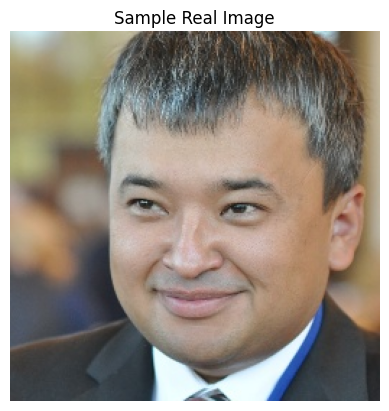

In [4]:
import matplotlib.pyplot as plt
import cv2
import random

sample_path = os.path.join(train_real, random.choice(os.listdir(train_real)))
img = plt.imread(sample_path)

print("Sample image path:", sample_path)
print("Image shape:", img.shape)
print("Data type:", img.dtype)

plt.imshow(img)
plt.title("Sample Real Image")
plt.axis("off")
plt.show()


## Distribution of Data in Dataset

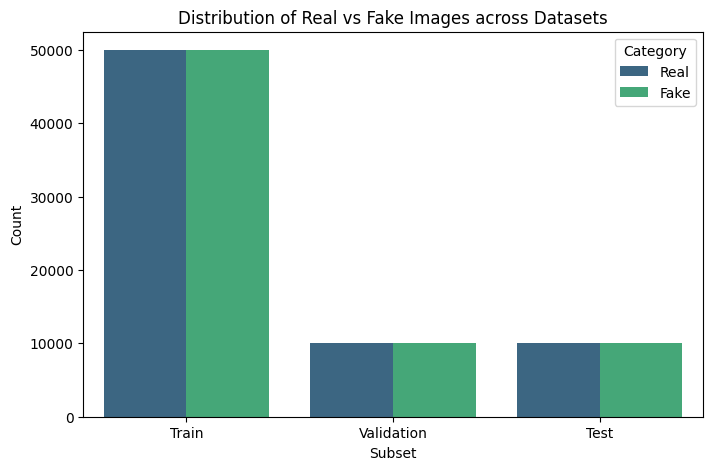

In [5]:
import pandas as pd
import seaborn as sns

data_counts = {
    'Subset': ['Train', 'Train', 'Validation', 'Validation', 'Test', 'Test'],
    'Category': ['Real', 'Fake', 'Real', 'Fake', 'Real', 'Fake'],
    'Count': [len(os.listdir(train_real)), len(os.listdir(train_fake)),
              len(os.listdir(val_real)), len(os.listdir(val_fake)),
              len(os.listdir(test_real)), len(os.listdir(test_fake))]
}

df_counts = pd.DataFrame(data_counts)

plt.figure(figsize=(8,5))
sns.barplot(x="Subset", y="Count", hue="Category", data=df_counts, palette="viridis")
plt.title("Distribution of Real vs Fake Images across Datasets")
plt.show()


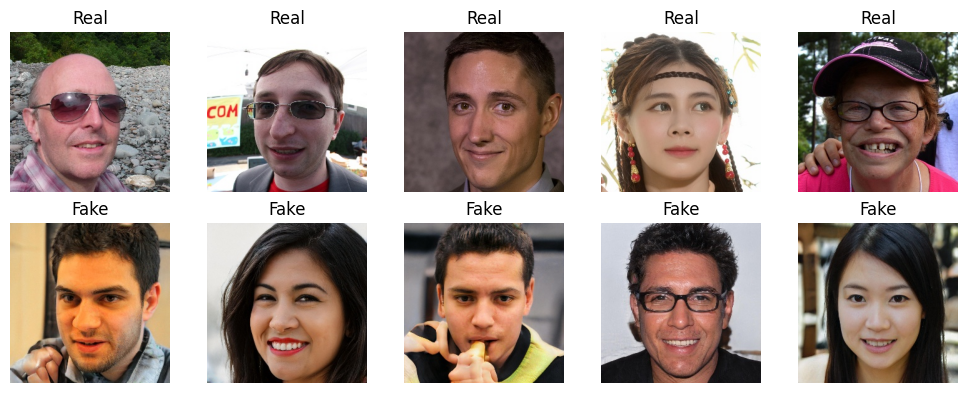

In [6]:
def show_samples(real_dir, fake_dir, n=5):
    plt.figure(figsize=(10, 4))

    real_imgs = random.sample(os.listdir(real_dir), n)
    fake_imgs = random.sample(os.listdir(fake_dir), n)

    for i, img_name in enumerate(real_imgs):
        plt.subplot(2, n, i + 1)
        img = plt.imread(os.path.join(real_dir, img_name))
        plt.imshow(img)
        plt.title("Real")
        plt.axis("off")

    for i, img_name in enumerate(fake_imgs):
        plt.subplot(2, n, n + i + 1)
        img = plt.imread(os.path.join(fake_dir, img_name))
        plt.imshow(img)
        plt.title("Fake")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

show_samples(train_real, train_fake)


In [7]:
import numpy as np

shapes = []
for folder in [train_real, train_fake]:
    for img_name in random.sample(os.listdir(folder), 50):  # sample 50 for speed
        img = plt.imread(os.path.join(folder, img_name))
        shapes.append(img.shape)

unique_shapes = np.unique(np.array(shapes), axis=0)
print("Unique image dimensions (sample of 100):", unique_shapes)


Unique image dimensions (sample of 100): [[256 256   3]]


# Phase 2:- Datapreprocessing and Data Augmentation

In [8]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt


## Resizing images to 224×224 standard for ResNet/EfficientNet and Batch size of 32

In [9]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_dir = "/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/train"
val_dir   = "/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/valid"
test_dir  = "/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test"



# Data Augmentation in Real Time for Training Data

In [10]:
# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,               # Normalize pixel values
    rotation_range=20,            # Random rotations
    width_shift_range=0.1,        # Horizontal shifts
    height_shift_range=0.1,       # Vertical shifts
    zoom_range=0.1,               # Random zooms
    horizontal_flip=True          # Random horizontal flips
)

val_test_datagen = ImageDataGenerator(rescale=1./255)  # Only rescaling


In [11]:
# Training generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)

# Validation generator
val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

# Test generator
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)


Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


In [12]:
x_batch, y_batch = next(train_generator)
print("Batch shape:", x_batch.shape, y_batch.shape)


Batch shape: (32, 224, 224, 3) (32,)


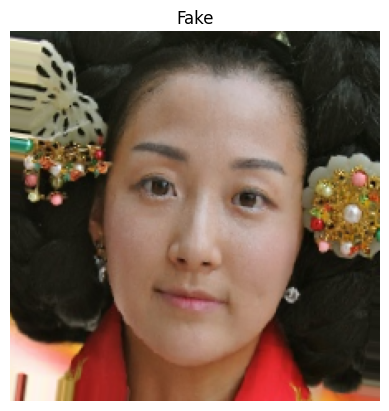

In [13]:
plt.imshow(x_batch[0])
plt.title("Real" if y_batch[0]==0 else "Fake")
plt.axis("off")
plt.show()


# Phase -3 Creation of Baseline CNN model 

Baseline :- Architecture 

Conv → BatchNorm → ReLU → MaxPool

Conv → BatchNorm → ReLU → MaxPool

Conv → BatchNorm → ReLU → MaxPool

Flatten → Dense → Dropout → Dense(1)

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam


In [15]:
baseline_cnn = Sequential([
    
    Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Flatten(),

    Dense(256, activation='relu'),
    Dropout(0.5),

    Dense(1, activation='sigmoid')  # Binary classification
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1765638809.739456      38 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [16]:
baseline_cnn.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy']
)


In [17]:
baseline_cnn.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,245,825 (84.86 MB)

 Trainable params: 22,245,377 (84.86 MB)

 Non-trainable params: 448 (1.75 KB)

In [18]:
history_baseline = baseline_cnn.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1765638816.114390     128 service.cc:148] XLA service 0x2a130d50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765638816.115160     128 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1765638816.723382     128 cuda_dnn.cc:529] Loaded cuDNN version 90300


   1/3125 ━━━━━━━━━━━━━━━━━━━━ 8:16:50 10s/step - accuracy: 0.4688 - loss: 1.2389

I0000 00:00:1765638821.457794     128 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1880s 599ms/step - accuracy: 0.6184 - loss: 0.7124 - val_accuracy: 0.7059 - val_loss: 0.5592
Epoch 2/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1247s 399ms/step - accuracy: 0.7097 - loss: 0.5668 - val_accuracy: 0.7327 - val_loss: 0.5424
Epoch 3/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1216s 389ms/step - accuracy: 0.7468 - loss: 0.5170 - val_accuracy: 0.8008 - val_loss: 0.4374
Epoch 4/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1243s 398ms/step - accuracy: 0.7782 - loss: 0.4707 - val_accuracy: 0.8287 - val_loss: 0.3863
Epoch 5/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1228s 393ms/step - accuracy: 0.8121 - loss: 0.4178 - val_accuracy: 0.8101 - val_loss: 0.4206
Epoch 6/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1263s 404ms/step - accuracy: 0.8381 - loss: 0.3716 - val_accuracy: 0.8496 - val_loss: 0.3735
Epoch 7/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1232s 394ms/step - accuracy: 0.8566 - loss: 0.3423 - val_accuracy: 0.8574 - val_loss: 0.3333
Epoch 8/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1247s 399ms/step - accur

In [19]:
baseline_test_loss, baseline_test_acc = baseline_cnn.evaluate(test_generator)
print("Baseline CNN Test Accuracy:", baseline_test_acc)


625/625 ━━━━━━━━━━━━━━━━━━━━ 127s 203ms/step - accuracy: 0.8436 - loss: 0.3547
Baseline CNN Test Accuracy: 0.8803499937057495


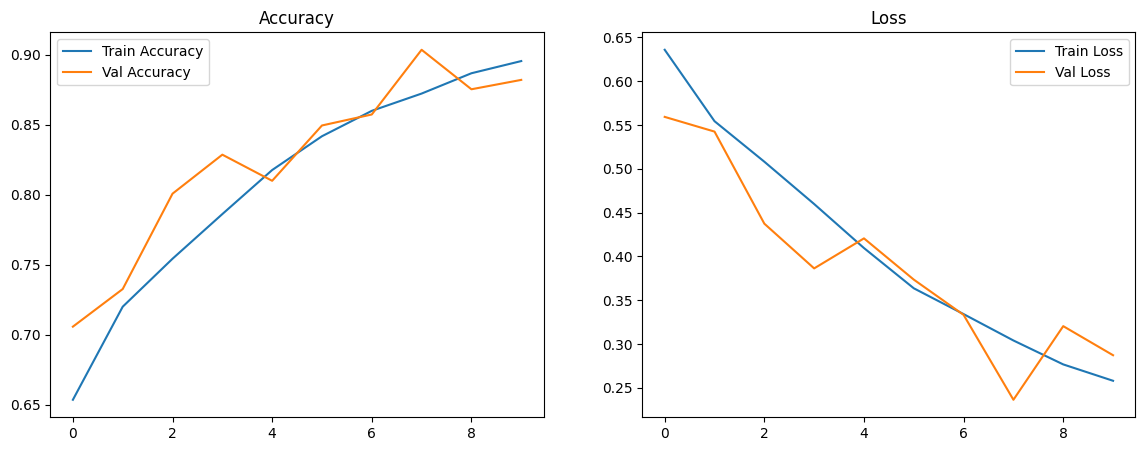

In [20]:
import matplotlib.pyplot as plt

acc = history_baseline.history['accuracy']
val_acc = history_baseline.history['val_accuracy']
loss = history_baseline.history['loss']
val_loss = history_baseline.history['val_loss']

plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(acc, label='Train Accuracy')
plt.plot(val_acc, label='Val Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.title('Loss')
plt.legend()

plt.show()


# Confusion Matrix 


625/625 ━━━━━━━━━━━━━━━━━━━━ 38s 61ms/step


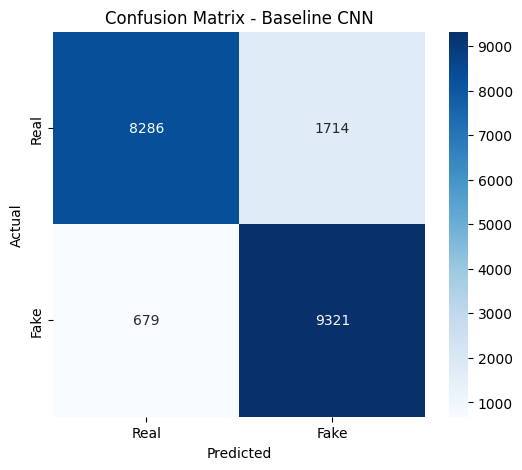

In [21]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions
y_pred = baseline_cnn.predict(test_generator)
y_pred = (y_pred > 0.5).astype(int)

# True labels
y_true = test_generator.classes

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real','Fake'],
            yticklabels=['Real','Fake'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Baseline CNN')
plt.show()


# CLASSIFICATION REPORT

In [22]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=['Real', 'Fake']))


              precision    recall  f1-score   support

        Real       0.92      0.83      0.87     10000
        Fake       0.84      0.93      0.89     10000

    accuracy                           0.88     20000
   macro avg       0.88      0.88      0.88     20000
weighted avg       0.88      0.88      0.88     20000



# ROC CURVE + AUC SCORE

625/625 ━━━━━━━━━━━━━━━━━━━━ 38s 60ms/step


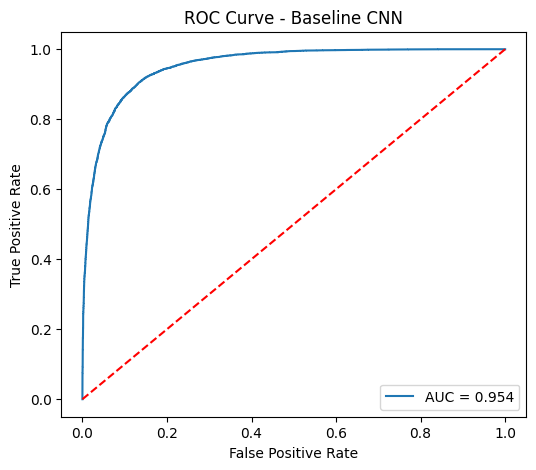

AUC Score: 0.9539310249999999


In [23]:
from sklearn.metrics import roc_curve, auc

y_pred_prob = baseline_cnn.predict(test_generator)

fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label='AUC = %0.3f' % roc_auc)
plt.plot([0,1],[0,1], 'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Baseline CNN')
plt.legend(loc='lower right')
plt.show()

print("AUC Score:", roc_auc)


In [24]:
baseline_cnn.save("baseline_cnn_model.h5")
print("Model saved as baseline_cnn_model.h5")


Model saved as baseline_cnn_model.h5


In [25]:
train_generator.class_indices


{'fake': 0, 'real': 1}

In [26]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.applications import ResNet50, EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc


# 4.1 Load pretrained ResNet50 and freeze

Load pretrained ResNet50 and freeze

In [27]:
base_resnet = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)
base_resnet.trainable = False


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## Add classification head

In [28]:
x = base_resnet.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation='sigmoid')(x)

resnet_model = Model(inputs=base_resnet.input, outputs=output)


## Compile

In [29]:
resnet_model.compile(
    optimizer=Adam(1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
resnet_model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,112,513 (91.98 MB)

 Trainable params: 524,801 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

## Train the top layers (frozen base)

In [30]:
checkpoint_resnet_top = ModelCheckpoint(
    "resnet50_top.h5", save_best_only=True, monitor="val_loss"
)

early_stop = EarlyStopping(
    monitor='val_loss', patience=4, restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', patience=2, factor=0.5
)

history_resnet_top = resnet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=8,
    callbacks=[checkpoint_resnet_top, early_stop, reduce_lr]
)


Epoch 1/8
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1255s 397ms/step - accuracy: 0.5223 - loss: 0.7041 - val_accuracy: 0.5755 - val_loss: 0.6801 - learning_rate: 1.0000e-04
Epoch 2/8
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1214s 389ms/step - accuracy: 0.5538 - loss: 0.6851 - val_accuracy: 0.5876 - val_loss: 0.6746 - learning_rate: 1.0000e-04
Epoch 3/8
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1225s 392ms/step - accuracy: 0.5604 - loss: 0.6819 - val_accuracy: 0.5832 - val_loss: 0.6732 - learning_rate: 1.0000e-04
Epoch 4/8
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1241s 397ms/step - accuracy: 0.5684 - loss: 0.6795 - val_accuracy: 0.5989 - val_loss: 0.6670 - learning_rate: 1.0000e-04
Epoch 5/8
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1255s 402ms/step - accuracy: 0.5743 - loss: 0.6765 - val_accuracy: 0.6009 - val_loss: 0.6658 - learning_rate: 1.0000e-04
Epoch 6/8
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1231s 394ms/step - accuracy: 0.5767 - loss: 0.6747 - val_accuracy: 0.5932 - val_loss: 0.6680 - learning_rate: 1.0000e-04
Epoch 7/8
3125/3125 ━━━━━━━━

## Fine-tune (unfreeze top layers)

In [32]:
# Unfreeze last 20 layers of ResNet50
for layer in base_resnet.layers[-20:]:
    layer.trainable = True

resnet_model.compile(
    optimizer=Adam(1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

checkpoint_resnet_ft = ModelCheckpoint(
    "resnet50_finetuned.h5", save_best_only=True, monitor="val_loss"
)

history_resnet_ft = resnet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=8,
    callbacks=[checkpoint_resnet_ft, early_stop, reduce_lr]
)


Epoch 1/8
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1195s 376ms/step - accuracy: 0.6753 - loss: 0.6025 - val_accuracy: 0.6837 - val_loss: 0.5963 - learning_rate: 1.0000e-05
Epoch 2/8
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1152s 368ms/step - accuracy: 0.6865 - loss: 0.5959 - val_accuracy: 0.6956 - val_loss: 0.5874 - learning_rate: 1.0000e-05
Epoch 3/8
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1152s 369ms/step - accuracy: 0.6868 - loss: 0.5891 - val_accuracy: 0.6669 - val_loss: 0.6415 - learning_rate: 1.0000e-05
Epoch 4/8
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1148s 367ms/step - accuracy: 0.6941 - loss: 0.5799 - val_accuracy: 0.7225 - val_loss: 0.5484 - learning_rate: 1.0000e-05
Epoch 5/8
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1179s 377ms/step - accuracy: 0.7045 - loss: 0.5713 - val_accuracy: 0.7262 - val_loss: 0.5379 - learning_rate: 1.0000e-05
Epoch 6/8
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1203s 385ms/step - accuracy: 0.7040 - loss: 0.5704 - val_accuracy: 0.7293 - val_loss: 0.5314 - learning_rate: 1.0000e-05
Epoch 7/8
3125/3125 ━━━━━━━━

## Save model After Training 

In [34]:
resnet_model.save("resnet50_final.h5")


# Load base EfficientNetB0 & freeze

In [35]:
base_eff = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)
base_eff.trainable = False


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## Add Classification Header

In [36]:
y = base_eff.output
y = layers.GlobalAveragePooling2D()(y)
y = layers.Dense(256, activation='relu')(y)
y = layers.Dropout(0.5)(y)
output_eff = layers.Dense(1, activation='sigmoid')(y)

eff_model = Model(inputs=base_eff.input, outputs=output_eff)


## Compile 

In [37]:
eff_model.compile(
    optimizer=Adam(1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
eff_model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer_2[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,377,764 (16.70 MB)

 Trainable params: 328,193 (1.25 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

## Begin Training

In [ ]:
checkpoint_eff_top = ModelCheckpoint(
    "effnet_top.h5", save_best_only=True, monitor="val_loss"
)

history_eff_top = eff_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=8,
    callbacks=[checkpoint_eff_top, early_stop, reduce_lr]
)


## Fine Tuning 

In [ ]:
for layer in base_eff.layers[-20:]:
    layer.trainable = True

eff_model.compile(
    optimizer=Adam(1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

checkpoint_eff_ft = ModelCheckpoint(
    "effnet_finetuned.h5", save_best_only=True, monitor="val_loss"
)

history_eff_ft = eff_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=8,
    callbacks=[checkpoint_eff_ft, early_stop, reduce_lr]
)


## Save Model

In [ ]:
eff_model.save("effnetb0_final.h5")


# Phase-5 Load the best model

In [ ]:
from tensorflow.keras.models import load_model

best_eff_model = load_model("effnetb0_final.h5")


## Ensuring Test Generator is Correct

In [ ]:
test_generator.reset()


## Evaluate on Test Set (Accuracy & Loss)

In [ ]:
test_loss, test_accuracy = best_eff_model.evaluate(test_generator)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")


## Get Predictions

In [ ]:
import numpy as np

y_pred_prob = best_eff_model.predict(test_generator)
y_pred = (y_pred_prob > 0.5).astype(int).ravel()

y_true = test_generator.classes


## Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Fake", "Real"],
            yticklabels=["Fake", "Real"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("EfficientNetB0 – Confusion Matrix")
plt.show()


In [ ]:
print(classification_report(
    y_true,
    y_pred,
    target_names=["Fake", "Real"]
))


## ROC curve and score

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve

roc_auc = roc_auc_score(y_true, y_pred_prob)
print(f"ROC-AUC Score: {roc_auc:.4f}")

fpr, tpr, _ = roc_curve(y_true, y_pred_prob)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – EfficientNetB0")
plt.legend()
plt.show()
